In [1]:
!nvidia-smi

Sun Sep 18 03:47:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Wrangling 

## Data Exploration and Preparation 

In [108]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torch_snippets import *
import glob
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms

In [109]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [110]:
df = pd.read_csv('../input/self-driving-cars/labels_train.csv')
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [111]:
df['xmin'].loc[(df['xmin'] == 0)] = 1
df['ymin'].loc[(df['ymin'] == 0)] = 1
df['xmax'].loc[(df['xmax'] == 0)] = 1
df['ymax'].loc[(df['ymax'] == 0)] = 1

In [112]:
df = df[:60000]

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   frame     60000 non-null  object
 1   xmin      60000 non-null  int64 
 2   xmax      60000 non-null  int64 
 3   ymin      60000 non-null  int64 
 4   ymax      60000 non-null  int64 
 5   class_id  60000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 2.7+ MB


In [114]:
 a = list(enumerate(df.frame.values))

In [115]:
def new_df(df):
    for (i, fname) in a:
        fpath = f'../input/self-driving-cars/images/{fname}'
        img = np.asarray(Image.open(fpath))
        h ,w ,_ = img.shape
        df['xmin'].iloc[i] = df['xmin'].iloc[i]/w
        df['xmax'].iloc[i] = df['xmax'].iloc[i]/w
        df['ymin'].iloc[i] = df['ymin'].iloc[i]/h
        df['ymax'].iloc[i] = df['ymax'].iloc[i]/h
    return df 
df1 = new_df(df)
df1.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,0.493750,0.522917,0.476667,0.516667,1
1,1478019952686311006.jpg,0.910417,0.945833,0.400000,0.620000,3
2,1478019953180167674.jpg,0.454167,0.481250,0.486667,0.526667,1
3,1478019953689774621.jpg,0.356250,0.379167,0.470000,0.513333,2
4,1478019953689774621.jpg,0.372917,0.397917,0.480000,0.516667,1


In [116]:
df1 = df1[df1['xmin']>=0.1]
df1 = df1[df1['xmax']>=0.1]
df1 = df1[df1['ymin']>=0.1]
df1 = df1[df1['ymax']>=0.1]

In [119]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53633 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   frame     53633 non-null  object 
 1   xmin      53633 non-null  float64
 2   xmax      53633 non-null  float64
 3   ymin      53633 non-null  float64
 4   ymax      53633 non-null  float64
 5   class_id  53633 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.9+ MB


In [121]:
df1.describe()

,xmin,xmax,ymin,ymax,class_id
count,53633.000000,53633.000000,53633.000000,53633.000000,53633.000000
mean,0.456546,0.519592,0.439753,0.529769,2.065035
std,0.203784,0.211894,0.073242,0.101069,1.627243
min,0.100000,0.112500,0.100000,0.153333,1.000000
25%,0.297917,0.358333,0.420000,0.503333,1.000000
50%,0.447917,0.493750,0.463333,0.540000,1.000000
75%,0.591667,0.658333,0.483333,0.573333,3.000000
max,0.987500,0.997917,0.690000,0.996667,5.000000


In [122]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53633 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   frame     53633 non-null  object 
 1   xmin      53633 non-null  float64
 2   xmax      53633 non-null  float64
 3   ymin      53633 non-null  float64
 4   ymax      53633 non-null  float64
 5   class_id  53633 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 2.9+ MB


In [91]:
df1.columns

Index(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], dtype='object')

In [153]:
labels = { 0:'backgroud',
          1:'car',
          2:'truck',
          3:'pedestrian', 
          4:'bicyclist', 
          5:'light'}
target2labels = labels.copy()
target2labels 

{0: 'backgroud',
 1: 'car',
 2: 'truck',
 3: 'pedestrian',
 4: 'bicyclist',
 5: 'light'}

In [48]:
num_classes = len(labels)
num_classes

6

(300, 480, 3)

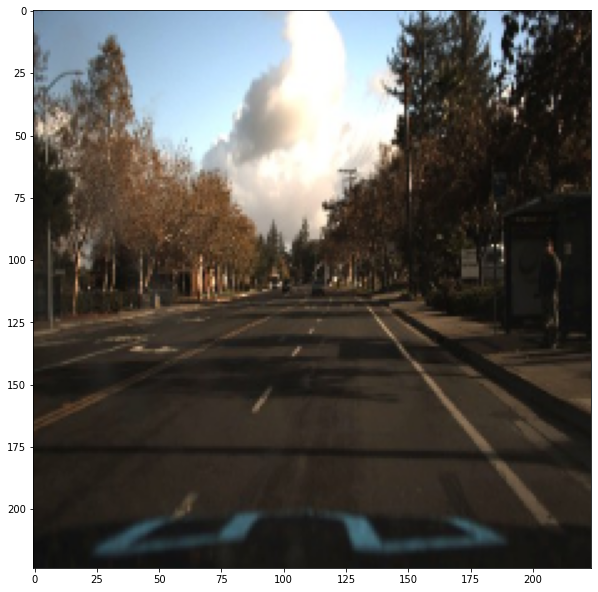

In [69]:
img1 = cv2.imread('../input/self-driving-cars/images/1478019952686311006.jpg')
img = img1.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img , (224,224))
plt.figure(figsize=(10,13))
plt.imshow(img)
img1.shape

In [73]:
h , w , _ = img1.shape
h ,w

(300, 480)

In [94]:
img_id = '1478732595079673268.jpg'
img_details = df1[df1['frame']==img_id]
img_details

,frame,xmin,xmax,ymin,ymax,class_id
24991,1478732595079673268.jpg,0.258333,0.279167,0.376667,0.430000,5
24992,1478732595079673268.jpg,0.329167,0.372917,0.470000,0.533333,1
24993,1478732595079673268.jpg,0.372917,0.391667,0.480000,0.523333,1
24994,1478732595079673268.jpg,0.393750,0.410417,0.473333,0.526667,1
24995,1478732595079673268.jpg,0.414583,0.429167,0.466667,0.513333,1
24996,1478732595079673268.jpg,0.477083,0.525000,0.446667,0.536667,1
24997,1478732595079673268.jpg,0.516667,0.537500,0.280000,0.323333,5
24998,1478732595079673268.jpg,0.533333,0.577083,0.466667,0.520000,1
24999,1478732595079673268.jpg,0.622917,0.641667,0.380000,0.410000,5


In [95]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [131]:
class SeflDrivingCarDataset(Dataset):
  w , h = 224 , 224
  def __init__(self , df  , image_root_dir = '../input/self-driving-cars/images' ):
    self.image_dir = image_root_dir
    self.df = df
    self.files = glob.glob(self.image_dir + '/*.jpg')
    self.image_infos = df.frame.unique()

  def __len__(self):
    return len(self.image_infos)

  def __getitem__(self ,ix ):
    img_id = self.image_infos[ix]
    img_path = f'../input/self-driving-cars/images/{img_id}'
    img = Image.open(img_path).convert('RGB')
    img = np.array(img.resize((self.w ,self.h) , resample = Image.BILINEAR))/255.
    data = df[df['frame'] == img_id]
    labels = data['class_id'].values.tolist()
    data = data[['xmin', 'ymin' ,'xmax' ,'ymax']].values
    data[:,[0,2]] *=  self.w
    data[:,[1,3]] *=  self.h
    boxes = data.astype(np.uint32).tolist()
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([i for i in labels]).long()
    img = preprocess_image(img)
    return img , target 

  def collate_fn(self ,batch):
    return tuple(zip(*batch))

from sklearn.model_selection import train_test_split as tts

trn_ids , val_ids = tts(df1.frame.unique(),test_size =0.1,random_state =99)
trn_df , val_df = df1[df1['frame'].isin(trn_ids)] , df1[df1['frame'].isin(val_ids)]

train_ds = SeflDrivingCarDataset(trn_df)
val_ds = SeflDrivingCarDataset(val_df)

train_loader = DataLoader(train_ds ,  batch_size = 4, collate_fn = train_ds.collate_fn, drop_last =True)

val_loader = DataLoader(val_ds ,batch_size = 4, collate_fn = val_ds.collate_fn,drop_last =True )


In [132]:
len(train_ds) , len(val_ds)

(7538, 838)

## Model Building 

In [133]:
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained =True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor( in_features , 
                                                      num_classes )
  return model 

In [134]:
def train_batch(inputs, model , optimizer):
  model.train()
  input , targets = inputs 
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()
  return loss , losses 

@torch.no_grad()
def validate_batch(inputs, models):
  model.train()
  input , targets = inputs 
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  return loss ,losses


In [143]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters() , lr=0.005 , 
                            momentum = 0.9 , weight_decay= 0.0005 )

In [136]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Model Training 

In [137]:
loss_criterions = ['loss_classifier',
          'loss_box_reg',
          'loss_objectness',
          'loss_rpn_box_reg'] 

In [142]:
EPOCHS = 5

In [145]:
import time 
start = time.time()
tcl , trl , tol , trpnl ,ttl = [] ,[] ,[] ,[] ,[] 
vcl , vrl , vol , vrpnl ,vtl = [] ,[] ,[] ,[] ,[] 
for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  tecl , terl , teol , terpnl ,tetl = [] ,[] ,[] ,[] ,[] 
  vecl , verl , veol , verpnl ,vetl = [] ,[] ,[] ,[] ,[]
  for ix , batch in enumerate(train_loader):
    loss , losses = train_batch(batch , model , optimizer )
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    tecl.append(los_loss.detach().cpu().numpy()) , terl.append(reg_loss.detach().cpu().numpy()) , teol.append(loss_obj.detach().cpu().numpy()) 
    terpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,tetl.append(tot_loss.detach().cpu().numpy())
    if ix%600 == 0 and ix!=0:
        print(f'{ix} batches completed')
  print(f'Training - Total Loss {np.mean(tetl):.5f} | Classification Loss {np.mean(tecl):.5f} | Regression Loss {np.mean(terl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(teol):.5f} | RPN Loss {np.mean(terpnl):.5f}' )
  tcl.append(np.mean(tecl)) , trl.append(np.mean(terl)) , tol.append(np.mean(teol)) , trpnl.append(np.mean(terpnl)) ,ttl.append(np.mean(tetl))


  for ix , batch in enumerate(val_loader):
    loss , losses = validate_batch(batch ,model )
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    vecl.append(los_loss.detach().cpu().numpy()) , verl.append(reg_loss.detach().cpu().numpy()) , veol.append(loss_obj.detach().cpu().numpy()) 
    verpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,vetl.append(tot_loss.detach().cpu().numpy())
  
  print(f'Validation - Total Loss {np.mean(vetl):.5f} | Classification Loss {np.mean(vecl):.5f} | Regression Loss {np.mean(verl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(veol):.5f} | RPN Loss {np.mean(verpnl):.5f}' )

  vcl.append(np.mean(vecl)) , vrl.append(np.mean(verl)) , vol.append(np.mean(veol)) , vrpnl.append(np.mean(verpnl)) ,vtl.append(np.mean(vetl))

  print('===============================================================================Done')
  print()
print('                    ****************** Training Completed *****************                             ')
end = time.time()
total_time = end-start

EPOCH 1

600 batches completed

1200 batches completed

1800 batches completed

Training - Total Loss 0.63315 | Classification Loss 0.21145 | Regression Loss 0.34416

| Object Loss 0.04125 | RPN Loss 0.03630

Validation - Total Loss 0.71221 | Classification Loss 0.25769 | Regression Loss 0.36008

| Object Loss 0.05548 | RPN Loss 0.03895

===============================================================================Done

EPOCH 2

600 batches completed

1200 batches completed

1800 batches completed

Training - Total Loss 0.56963 | Classification Loss 0.18514 | Regression Loss 0.32515

| Object Loss 0.02769 | RPN Loss 0.03165

Validation - Total Loss 0.64322 | Classification Loss 0.22035 | Regression Loss 0.34443

| Object Loss 0.04199 | RPN Loss 0.03646

===============================================================================Done

EPOCH 3

600 batches completed

1200 batches completed

1800 batches completed

Training - Total Loss 0.53805 | Classification Loss 0.17234 | Regression Loss 0.31458

| Object Loss 0.02152 | RPN Loss 0.02961

Validation - Total Loss 0.62454 | Classification Loss 0.21272 | Regression Loss 0.33860

| Object Loss 0.03840 | RPN Loss 0.03482

===============================================================================Done

EPOCH 4

600 batches completed

1200 batches completed

1800 batches completed

Training - Total Loss 0.51635 | Classification Loss 0.16298 | Regression Loss 0.30719

| Object Loss 0.01817 | RPN Loss 0.02801

Validation - Total Loss 0.60931 | Classification Loss 0.20241 | Regression Loss 0.33060

| Object Loss 0.03823 | RPN Loss 0.03807

===============================================================================Done

EPOCH 5

600 batches completed

1200 batches completed

1800 batches completed

Training - Total Loss 0.50081 | Classification Loss 0.15657 | Regression Loss 0.30096

| Object Loss 0.01619 | RPN Loss 0.02710

Validation - Total Loss 0.61677 | Classification Loss 0.20430 | Regression Loss 0.33582

| Object Loss 0.04125 | RPN Loss 0.03540

===============================================================================Done

****************** Training Completed *****************

In [147]:
print(f'Total Time Taken : {total_time} seconds')

Total Time Taken : 4594.7082641124725 seconds

## Performance over Epochs 

In [160]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
def plot_pf(tl , vl , head):
    plt.plot(epochs, tl, 'b', label='Training loss')
    plt.plot(epochs, vl , 'r', label='Test loss')
    plt.title(head)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

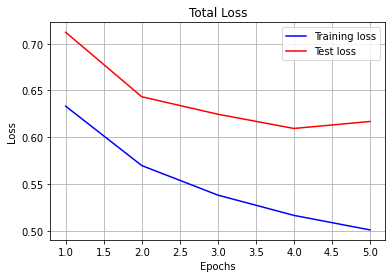

In [161]:
plot_pf(ttl ,vtl , "Total Loss")

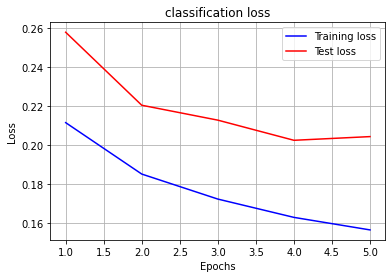

In [162]:
plot_pf(tcl , vcl ,'classification loss')

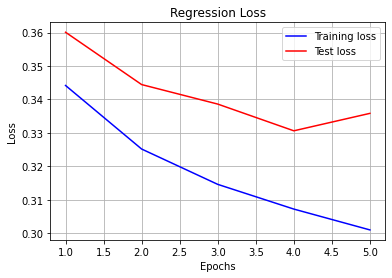

In [163]:
plot_pf(trl , vrl , "Regression Loss")

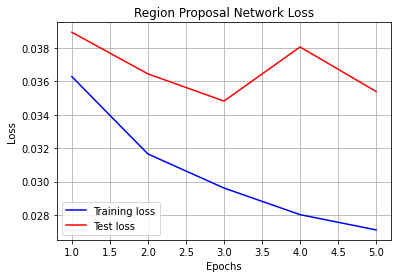

In [164]:
plot_pf(trpnl, vrpnl , "Region Proposal Network Loss")

## Evaluation and Testing

In [148]:
print(f'''tcl = {tcl}  
      trl = {trl} 
      tol = {tol} 
      trpnl = {trpnl} 
      ttl = {ttl}''')
      

tcl = [0.2114467, 0.18513876, 0.17234407, 0.1629793, 0.15656784]  
      trl = [0.34415793, 0.32514867, 0.314584, 0.30719155, 0.30095735] 
      tol = [0.041248914, 0.027688827, 0.021516483, 0.018167999, 0.01619016] 
      trpnl = [0.036296103, 0.03165421, 0.029609656, 0.028013963, 0.027097752] 
      ttl = [0.6331497, 0.5696305, 0.53805417, 0.51635283, 0.50081307]

In [149]:
print(f'''vcl = {vcl}  
      vrl = {vrl} 
      vol = {vol} 
      vrpnl = {vrpnl} 
      vtl = {vtl}''')

vcl = [0.25769046, 0.22034922, 0.21272074, 0.20241407, 0.20430355]  
      vrl = [0.36008158, 0.3444294, 0.33859524, 0.3306021, 0.3358188] 
      vol = [0.055484474, 0.041986365, 0.03839956, 0.038225614, 0.041251037] 
      vrpnl = [0.038953517, 0.0364567, 0.034824796, 0.03807094, 0.035398923] 
      vtl = [0.71221006, 0.6432217, 0.6245403, 0.6093127, 0.61677223]

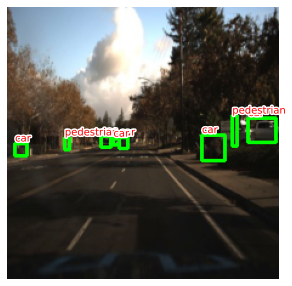

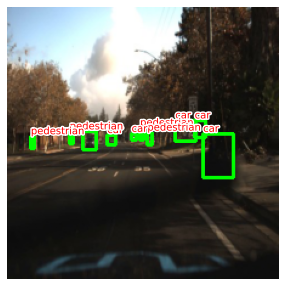

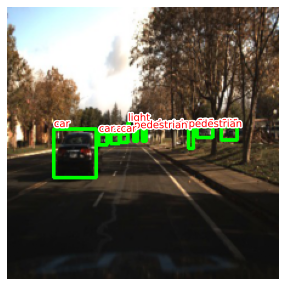

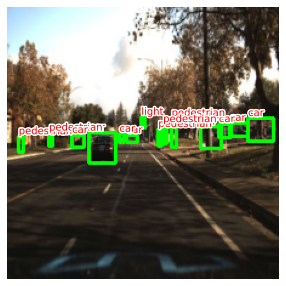

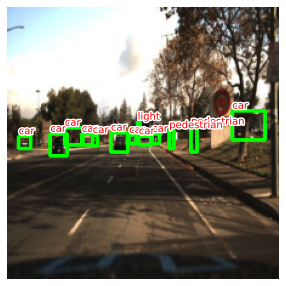

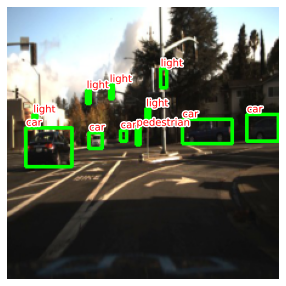

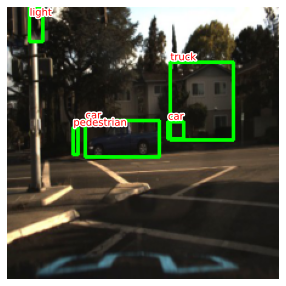

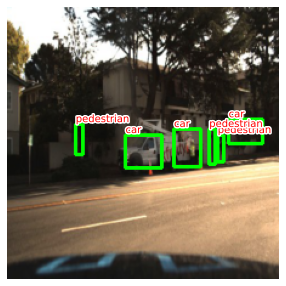

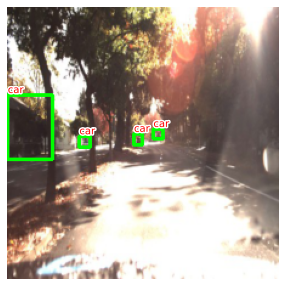

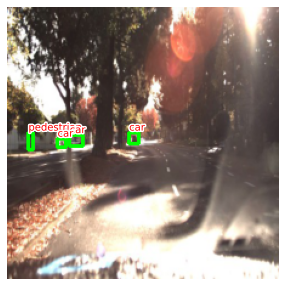

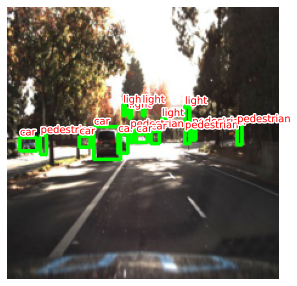

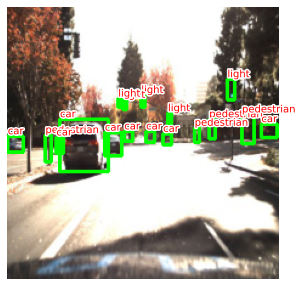

In [155]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2labels[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    # print(outputs)
    for ix, output in enumerate(outputs):
       bbs, confs, labels = decode_output(output)
       info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
       show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [158]:
torch.save(model.to('cpu').state_dict(), './Self-Driving-Car-FRCNN-V0-5epochs.pth')
## The model is performing very good 